# Configurações iniciais

In [1]:
# LIBS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
import re
import warnings 
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings('ignore') 
import seaborn as sns
import joblib

# CONFIGURAÇÕES

pd.set_option('display.max_rows',100) # Ajustando número máximo de linhas a serem exibidas por dataframes
pd.set_option('display.max_columns',100) # Ajustando número máximo de colunas a serem exibidas por dataframes
pd.set_option('display.width', 100) # Ajustando tamanho a ser exibido dos valores do dataframe
pd.set_option('display.float_format', lambda x: '%.4f' % x) # Ajustando o valor dos valores floats para 4 casas decimais
%config InlineBackend.figure_format = 'retina' # Ajustando a nitidez dos gráficos
SEED = 27 # Semente para reprodução de pseudo-aleatoriedade

# DIRETÓRIOS

project_data_path = '../data' # Diretório da base de dados
model_path = '../model' # Diretório para o modelo

# Preparando a base

In [2]:
# Aqui faço a leitura da base de dados a partir da variável 'project_data_path', na pasta 'raw' e o arquivo 'Travel_Chalenge.csv'

df = pd.read_csv(os.path.join(project_data_path, 'raw', 'Travel_Chalenge.csv'), sep = ';')
df.sample(3) # Uma amostra aleatória de 3 registros dos dados

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
5719,Croatia Airlines,2,"""I was treated in a disgusting and childish way""",19th May 2023,We recently did a flight from Dubrovnik to F...,NaN,Couple Leisure,Economy Class,Dubrovnik to Frankfurt,May 2023,3.0000,1.0000,2.0000,3.0000,1.0000,2.0000
16729,Oman Air,1,"""don't recommend anyone to fly with Oman Air""",8th December 2020,I have booked the tickets in July 2020 then ...,NaN,Family Leisure,Economy Class,Muscat to Cairo,August 2020,NaN,NaN,NaN,NaN,NaN,NaN
14181,Jetblue Airways,2,"""had a horrible experience""",3rd May 2023,I travelled JetBlue for the first time and h...,NaN,Business,Economy Class,New York to Milwaukee,May 2023,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


## Variável Target

In [3]:
# Tratando variável de interesse
df.loc[df['Overall_Rating'] == 'n', 'Overall_Rating'] = int(df.loc[df['Overall_Rating'] != 'n', 'Overall_Rating'].astype(int).median())
df['Overall_Rating'] = df['Overall_Rating'].astype(int)

In [4]:
# Criando classe de sentimentos para modelagem

def rules(rating):
    if rating < 4:
        return 'negative'
    elif rating >= 4 and rating <= 7:
        return 'neutral'
    else:
        return 'positive'
    
def encode_rules(class_col):
    if class_col == 'negative':
        return 0
    elif class_col == 'neutral':
        return 1
    elif class_col == 'positive':
        return 2


df.insert(2, 'Status', df['Overall_Rating'].apply(rules))
df.insert(3, 'Class', df['Status'].apply(encode_rules))

df.sample(3)

,Airline Name,Overall_Rating,Status,Class,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
12080,Air Transat,1,negative,0,"""Air Transat have done their best to ruin the ...",29th May 2022,Air Transat moved my flight to an earlier ti...,NaN,Solo Leisure,Premium Economy,London to Toronto,May 2022,1.0000,1.0000,NaN,1.0000,NaN,NaN
1064,Luxair,1,negative,0,Luxair customer review,11th October 2004,Economy from Manchester to Luxembourg. Very ni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15478,Asiana Airlines,1,negative,0,"""flight had been canceled""",6th April 2020,Seoul to Hanoi on 29th February booked throu...,NaN,Solo Leisure,Economy Class,Seoul to Hanoi,February 2020,NaN,NaN,NaN,1.0000,NaN,NaN


In [5]:
df['Class'].value_counts() # Variável de interesse desbalanceada

Class
0    12622
2     2545
1     2535
Name: count, dtype: int64

## Colunas de texto

In [6]:
def clean_text(text):
    # Converte o texto para minúsculas
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove menções (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove pontuações e caracteres especiais (exceto espaços)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove números
    text = re.sub(r'\d+', '', text)
    
    # Remove múltiplos espaços em branco
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# Removendo stopwords utilizando o idioma Inglês
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])


# Redução de palavras usando lemmatização
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Removendo emojis
def remove_emojis(text):
    return text.encode('ascii', 'ignore').decode('ascii')

# Considerando que a palavra 'not' pode inverter o sentido 
# Como por exemplo: "I absolutely loooove this product! It's not bad at all 😊",
# Nos casos de uso da palavra 'not', a função marca a próxima palavra e junta como uma única expressão, 
# Exemplo: 'not good' => 'not_good' 

def handle_negation(text):
    negation = "not"
    words = text.split()
    negated_sentence = []
    negate = False
    
    for word in words:
        if word == negation:
            negate = True
        elif negate:
            negated_sentence.append(f"not_{word}")
            negate = False
        else:
            negated_sentence.append(word)
    
    return ' '.join(negated_sentence)


def preprocess_text(text):
    text = handle_negation(text)
    text = clean_text(text)
    text = remove_stopwords(text)
    text = apply_lemmatization(text)
    return text


In [7]:
df.insert(7, 'Review_processed', df['Review'].apply(preprocess_text)) # Adicionando coluna de Review processada
df.insert(5, 'Review_Title_processed', df['Review_Title'].apply(preprocess_text)) # Adicionando coluna de Título da Review processada
df = df[(df['Review_Title_processed'] != '') & (df['Review_processed'] != '')] # Retirando inconsistências
df.sample(3)

,Airline Name,Overall_Rating,Status,Class,Review_Title,Review_Title_processed,Review Date,Review,Review_processed,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
14072,Luxair,1,negative,0,Luxair customer review,luxair customer review,3rd March 2007,Dub-Man-Dub. An airline which truly shows what...,dubmandub airline truly show service boarded b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5759,Air Europa,1,negative,0,"""asked for the taxes to be refunded",asked tax refunded,19th November 2021,I could not take my flight and asked for the...,could not_take flight asked tax refunded one t...,NaN,Business,Economy Class,Zurich to Madrid,November 2021,NaN,NaN,NaN,NaN,NaN,NaN
4859,Volaris,1,negative,0,"""This airline is terrible""",airline terrible,18th January 2023,This airline is terrible. They gave us issues...,airline terrible gave u issue way cancun way b...,NaN,Couple Leisure,Economy Class,Tijuana to Cancun,January 2023,1.0000,1.0000,1.0000,1.0000,1.0000,2.0000


In [8]:
# Adicionando "string coringa" para valores inválidos

df.loc[df['Aircraft'].isna(), 'Aircraft'] = 'No Info'
df.loc[df['Type Of Traveller'].isna(), 'Type Of Traveller'] = 'No Info'
df.loc[df['Seat Type'].isna(), 'Seat Type'] = 'No Info'
df.loc[df['Route'].isna(), 'Route'] = 'No Info'

In [9]:
df = df[~df.duplicated()] # Retirando duplicadas

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17672 entries, 0 to 17701
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            17672 non-null  object 
 1   Overall_Rating          17672 non-null  int64  
 2   Status                  17672 non-null  object 
 3   Class                   17672 non-null  int64  
 4   Review_Title            17672 non-null  object 
 5   Review_Title_processed  17672 non-null  object 
 6   Review Date             17672 non-null  object 
 7   Review                  17672 non-null  object 
 8   Review_processed        17672 non-null  object 
 9   Aircraft                17672 non-null  object 
 10  Type Of Traveller       17672 non-null  object 
 11  Seat Type               17672 non-null  object 
 12  Route                   17672 non-null  object 
 13  Date Flown              15943 non-null  object 
 14  Seat Comfort            15455 non-null  flo

# Início da modelagem

## Modelo 1

In [11]:
# a classe CombineTextColumns é um Transformer customizado para combinar duas colunas de texto de um DataFrame.
# Esta classe permite combinar o conteúdo de duas colunas específicas de texto em um DataFrame
# em uma única coluna concatenada.
# 'col1' e 'col2' são as colunas que deverão ser passadas para serem unidas em um único texto.

class CombineTextColumns(BaseEstimator, TransformerMixin):
    def __init__(self, col1: str = 'Review_Title', col2: str = 'Review'):
        self.col1 = col1 
        self.col2 = col2

    def fit(self, X, y=None):
        return self


    # O método transform realiza a combinação das colunas de texto.
    def transform(self, X):

        
        # Combina as colunas de texto
        X_combined = X[self.col1] + ' ' + X[self.col2]
        return X_combined


# FullTextPreprocessor é um Transformer customizado para pré-processamento básico de um texto.
# A classe realiza várias etapas de pré-processamento em dados textuais, incluindo:
# - Tratamento de casos de inversão de sentido por negação com uso do 'not'.
# - Limpeza de texto (remoção de URLs, menções, hashtags, pontuação, números e espaços extras).
# - Remoção de stopwords.
# - Lematização.
# - Remoção de emojis.

class FullTextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.preprocess_text(text) for text in X]

    # Realiza o pré-processamento completo em uma string de texto. Chamado pelo método `transform`.
    def preprocess_text(self, text):
        text = self.handle_negation(text)
        text = self.clean_text(text)
        text = self.remove_stopwords(text)
        text = self.apply_lemmatization(text)
        text = self.remove_emojis(text)
        return text
    
    # Limpa o texto removendo URLs, menções, hashtags, pontuação, números e espaços em excesso. Também converte o texto para minúsculas.
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # Remove stopwords do texto, baseando-se em uma lista de palavras irrelevantes em inglês.
    def remove_stopwords(self, text):
        return ' '.join([word for word in text.split() if word not in self.stop_words])

    # Aplica a lematização em cada palavra do texto, convertendo-as para suas formas básicas.
    def apply_lemmatization(self, text):
        return ' '.join([self.lemmatizer.lemmatize(word) for word in text.split()])

    # Remove emojis do texto, mantendo apenas caracteres ASCII.
    def remove_emojis(self, text):
        return text.encode('ascii', 'ignore').decode('ascii')

# Identifica negações que podem inverter o sentido no texto (palavras como "not") 
# e as aplica à próxima palavra, prefixando com "not_".
# Exemplo: "not good" -> "not_good".
    def handle_negation(self, text):
        negation = "not"
        words = text.split()
        negated_sentence = []
        negate = False
        
        for word in words:
            if word == negation:
                negate = True
            elif negate:
                negated_sentence.append(f"not_{word}")
                negate = False
            else:
                negated_sentence.append(word)
        
        return ' '.join(negated_sentence)

Como primeiro modelo, usarei a abordagem de utilizar apenas as colunas de texto referentes as Reviews como classificador dos sentimentos.

In [12]:
X = df[['Review_processed', 'Review_Title_processed']]
y = df['Class']

In [13]:
# Dividindo base entre treino e teste
# shuffle = True: Embaralha os dados durante a divisão
# stratify = y: Mantém as proporções da variável de interesse, no caso 'y'

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle = True, stratify = y, random_state = SEED) 

In [14]:
X_train.sample(5)

,Review_processed,Review_Title_processed
12434,ive terrible experience cathay flight phuket h...,airline completely irresponsible
10456,concerned rwandair flight reading negative rev...,cant speak highly enough
10360,flyer beware bait switch airline provide many ...,really value airline
5215,barcelona bucharest ridiculous service website...,ridiculous service website
11918,flown route time premium rouge firstly always ...,premium rouge seat uncomfortable


In [15]:
y_train.sample(5)

8208     0
4707     0
6201     0
12832    0
3964     0
Name: Class, dtype: int64

In [16]:
print("Tamanho de X_train:", len(X_train))
print("Tamanho de y_train:", len(y_train))
print("Tamanho de X_test:", len(X_test))
print("Tamanho de y_test:", len(y_test))

Tamanho de X_train: 12370
Tamanho de y_train: 12370
Tamanho de X_test: 5302
Tamanho de y_test: 5302


In [17]:
print(X_train.shape,y_train.shape)

(12370, 2) (12370,)


### Otimizando hiperparâmetros

Para otimizar os hiperparâmetros do modelo, utilizarei o método ``RandomizedSearchCV`` de forma aninhada.
A função ``randomizedsearch`` realiza uma busca aleatória de hiperparâmetros usando ``RandomizedSearchCV`` e avalia o desempenho do melhor modelo encontrado por meio da validação cruzada.

- ``StratifiedKFold``: Utilizado para dividir os dados em folds de maneira estratificada, preservando a proporção das classes (y).

- Já a validação cruzada externa é um método utilizado para avaliar o desempenho de um modelo de forma robusta e não tendenciosa, com objetivo de fornecer uma estimativa mais realista do desempenho do modelo quando aplicado a novos dados.

#### RandomizedSearchCV

In [18]:
# Função que realiza o RandomizedSearchCV para otimização de hiperparâmetros

def randomizedsearch(model, param_grid,  Xtrain, Ytrain, seed = SEED):
    icv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
    ocv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

    rs = RandomizedSearchCV(
        estimator = model, 
        param_distributions = param_grid, 
        scoring = 'accuracy', # métrica de avaliação
        # n_jobs = -1, 
        cv = icv 
    )

    rs_scores = cross_val_score(rs, Xtrain, Ytrain, cv = ocv)
    print(f'resultado de cada iteração do cv externo: {rs_scores}')
    print(f'média: {rs_scores.mean()}')

    return rs

In [19]:
param_grid = [
    {'Clf__solver' : ['newton-cg', 'lbfgs'],
      'Clf__penalty' : ['l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
    {'Clf__solver' : ['liblinear'],
      'Clf__penalty' : ['l1', 'l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
]

In [25]:
pipeline1 = Pipeline([
    ('JoinText', CombineTextColumns(col1 = 'Review_Title_processed', col2 = 'Review_processed')), # Transformer para combinar colunas de texto.
    ('Processor', FullTextPreprocessor()), # Transformer para ajustar texto.
    ('Tfidf', TfidfVectorizer(lowercase = True, max_features = 50)), # Converte o texto em uma matriz TF-IDF
    ('Clf', LogisticRegression()) # Modelo de classificação (Logistic Regression)
])

In [26]:
rs_mod1 = randomizedsearch(pipeline1, param_grid, X_train, y_train)

resultado de cada iteração do cv externo: [0.74130962 0.72433306 0.74090542 0.72716249 0.73403395]
média: 0.7335489086499596


In [27]:
rs_mod1

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('JoinText',
                                              CombineTextColumns(col1='Review_Title_processed',
                                                                 col2='Review_processed')),
                                             ('Processor',
                                              FullTextPreprocessor()),
                                             ('Tfidf',
                                              TfidfVectorizer(max_features=50)),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [28]:
rs_mod1.fit(X_train, y_train) # Ajustando os dados para obter os melhores hiperparâmetros segundo o RandomizedSearchCV

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('JoinText',
                                              CombineTextColumns(col1='Review_Title_processed',
                                                                 col2='Review_processed')),
                                             ('Processor',
                                              FullTextPreprocessor()),
                                             ('Tfidf',
                                              TfidfVectorizer(max_features=50)),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [29]:
rs_mod1.best_params_

{'Clf__solver': 'lbfgs',
 'Clf__penalty': 'l2',
 'Clf__max_iter': np.int64(300),
 'Clf__C': 1}

In [30]:
mod1_best_params = {key.split('__')[1]: value for key, value in rs_mod1.best_params_.items()}
mod1_best_params

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': np.int64(300), 'C': 1}

In [32]:
# Avaliando classificador em base de teste

opt_mod1 = Pipeline([
    ('JoinText', CombineTextColumns(col1 = 'Review_Title_processed', col2 = 'Review_processed')),
    ('Processor', FullTextPreprocessor()),
    ('Tfidf', TfidfVectorizer(lowercase = True, max_features = 50)),          
    ('Clf', LogisticRegression(**mod1_best_params))          
])

opt_mod1.fit(X_train, y_train)
mod1_predict = opt_mod1.predict(X_test)

report = classification_report(y_test, mod1_predict)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      3778
           1       0.45      0.07      0.11       760
           2       0.48      0.39      0.43       764

    accuracy                           0.74      5302
   macro avg       0.57      0.47      0.47      5302
weighted avg       0.69      0.74      0.69      5302



## Modelo 2

In [33]:
# Transformer customizado para imputação de valores ausentes nas colunas de avaliações.
# O critério para uso da média ou mediana foi abordado em `data_exploration.ipynb`.  
# Esta classe calcula a média ou mediana para colunas específicas durante a etapa de ajuste (fit)
# e, em seguida, utiliza esses valores para substituir valores ausentes nas colunas correspondentes
# durante a etapa de transformação. 
# Para os casos das variáveis 'Food & Beverages', 'Inflight Entertainment', 'Wifi & Connectivity', 
# ela cria novas colunas binárias indicando onde os valores ausentes estavam presentes nas colunas de interesse, devido
# a maior frequência de valores inválidos.


class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):

        # Verifica se X é um DataFrame e armazena as médias e medianas
        if isinstance(X, pd.DataFrame):
            self.means = {
                'Seat Comfort': int(X.loc[~X['Seat Comfort'].isna(), 'Seat Comfort'].astype(int).mean()),
                'Cabin Staff Service': int(X.loc[~X['Cabin Staff Service'].isna(), 'Cabin Staff Service'].astype(int).mean()),
                'Ground Service': int(X.loc[~X['Ground Service'].isna(), 'Ground Service'].astype(int).median()),
                'Food & Beverages': int(X.loc[~X['Food & Beverages'].isna(), 'Food & Beverages'].astype(int).median()),
                'Inflight Entertainment': int(X.loc[~X['Inflight Entertainment'].isna(), 'Inflight Entertainment'].astype(int).median()),
                'Wifi & Connectivity': int(X.loc[~X['Wifi & Connectivity'].isna(), 'Wifi & Connectivity'].astype(int).median())
            }
        return self
    
    def transform(self, X):

        X = X.copy()
        
        # Substituindo valores ausentes
        for col, value in self.means.items():
            if col in X.columns:
                X[col].fillna(value, inplace=True)
                X[col] = X[col].astype(int)
                
        # Criar variáveis para valores ausentes
        for col in ['Food & Beverages', 'Inflight Entertainment', 'Wifi & Connectivity']:
            if col in X.columns:
                X[f'{col}_isnan'] = X[col].isna().astype(int)
        
        return X

In [34]:
X2 = df.iloc[:, 14:]
y2 = df['Class']

In [35]:
X2.isnull().sum()

Seat Comfort               2217
Cabin Staff Service        2307
Food & Beverages           5748
Ground Service             2617
Inflight Entertainment     8441
Wifi & Connectivity       12429
dtype: int64

In [36]:
X2[X2.isna()]

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
17697,NaN,NaN,NaN,NaN,NaN,NaN
17698,NaN,NaN,NaN,NaN,NaN,NaN
17699,NaN,NaN,NaN,NaN,NaN,NaN
17700,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size = 0.3, shuffle = True, stratify = y, random_state = SEED) 

### Otimizando hiperparâmetros

#### RandomizedSearchCV

In [38]:
param_grid = [
    {'Clf__solver' : ['newton-cg', 'lbfgs'],
      'Clf__penalty' : ['l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
    {'Clf__solver' : ['liblinear'],
      'Clf__penalty' : ['l1', 'l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
]

In [39]:
## PIPELINE 2

pipeline2 = Pipeline([
    ('Inputer', CustomImputer()),
    ('Processor', StandardScaler()),
    ('Clf', LogisticRegression())
])

pipeline2.fit(X_train2, y_train2)
pipeline2_predict = pipeline2.predict(X_test2)

In [40]:
rs_mod2 = randomizedsearch(pipeline2, param_grid, X_train2, y_train2)

resultado de cada iteração do cv externo: [0.69846403 0.71341956 0.69927243 0.70573969 0.70169766]
média: 0.7037186742118028


In [41]:
rs_mod2.fit(X_train2, y_train2)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('Inputer', CustomImputer()),
                                             ('Processor', StandardScaler()),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [42]:
rs_mod2.best_params_

{'Clf__solver': 'liblinear',
 'Clf__penalty': 'l1',
 'Clf__max_iter': np.int64(400),
 'Clf__C': 30}

In [43]:
mod2_best_params = {key.split('__')[1]: value for key, value in rs_mod2.best_params_.items()}
mod2_best_params

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': np.int64(400), 'C': 30}

In [44]:
opt_mod2 = pipeline2 = Pipeline([
    ('Inputer', CustomImputer()),
    ('Processor', StandardScaler()),
    ('Clf', LogisticRegression(**mod2_best_params))           
])

opt_mod2.fit(X_train2, y_train2)
mod2_predict = opt_mod2.predict(X_test2)

report2 = classification_report(y_test2, mod2_predict)
print(report2)

              precision    recall  f1-score   support

           0       0.75      0.89      0.82      3778
           1       0.43      0.00      0.01       760
           2       0.44      0.46      0.45       764

    accuracy                           0.70      5302
   macro avg       0.54      0.45      0.43      5302
weighted avg       0.66      0.70      0.65      5302



# Comparando modelos

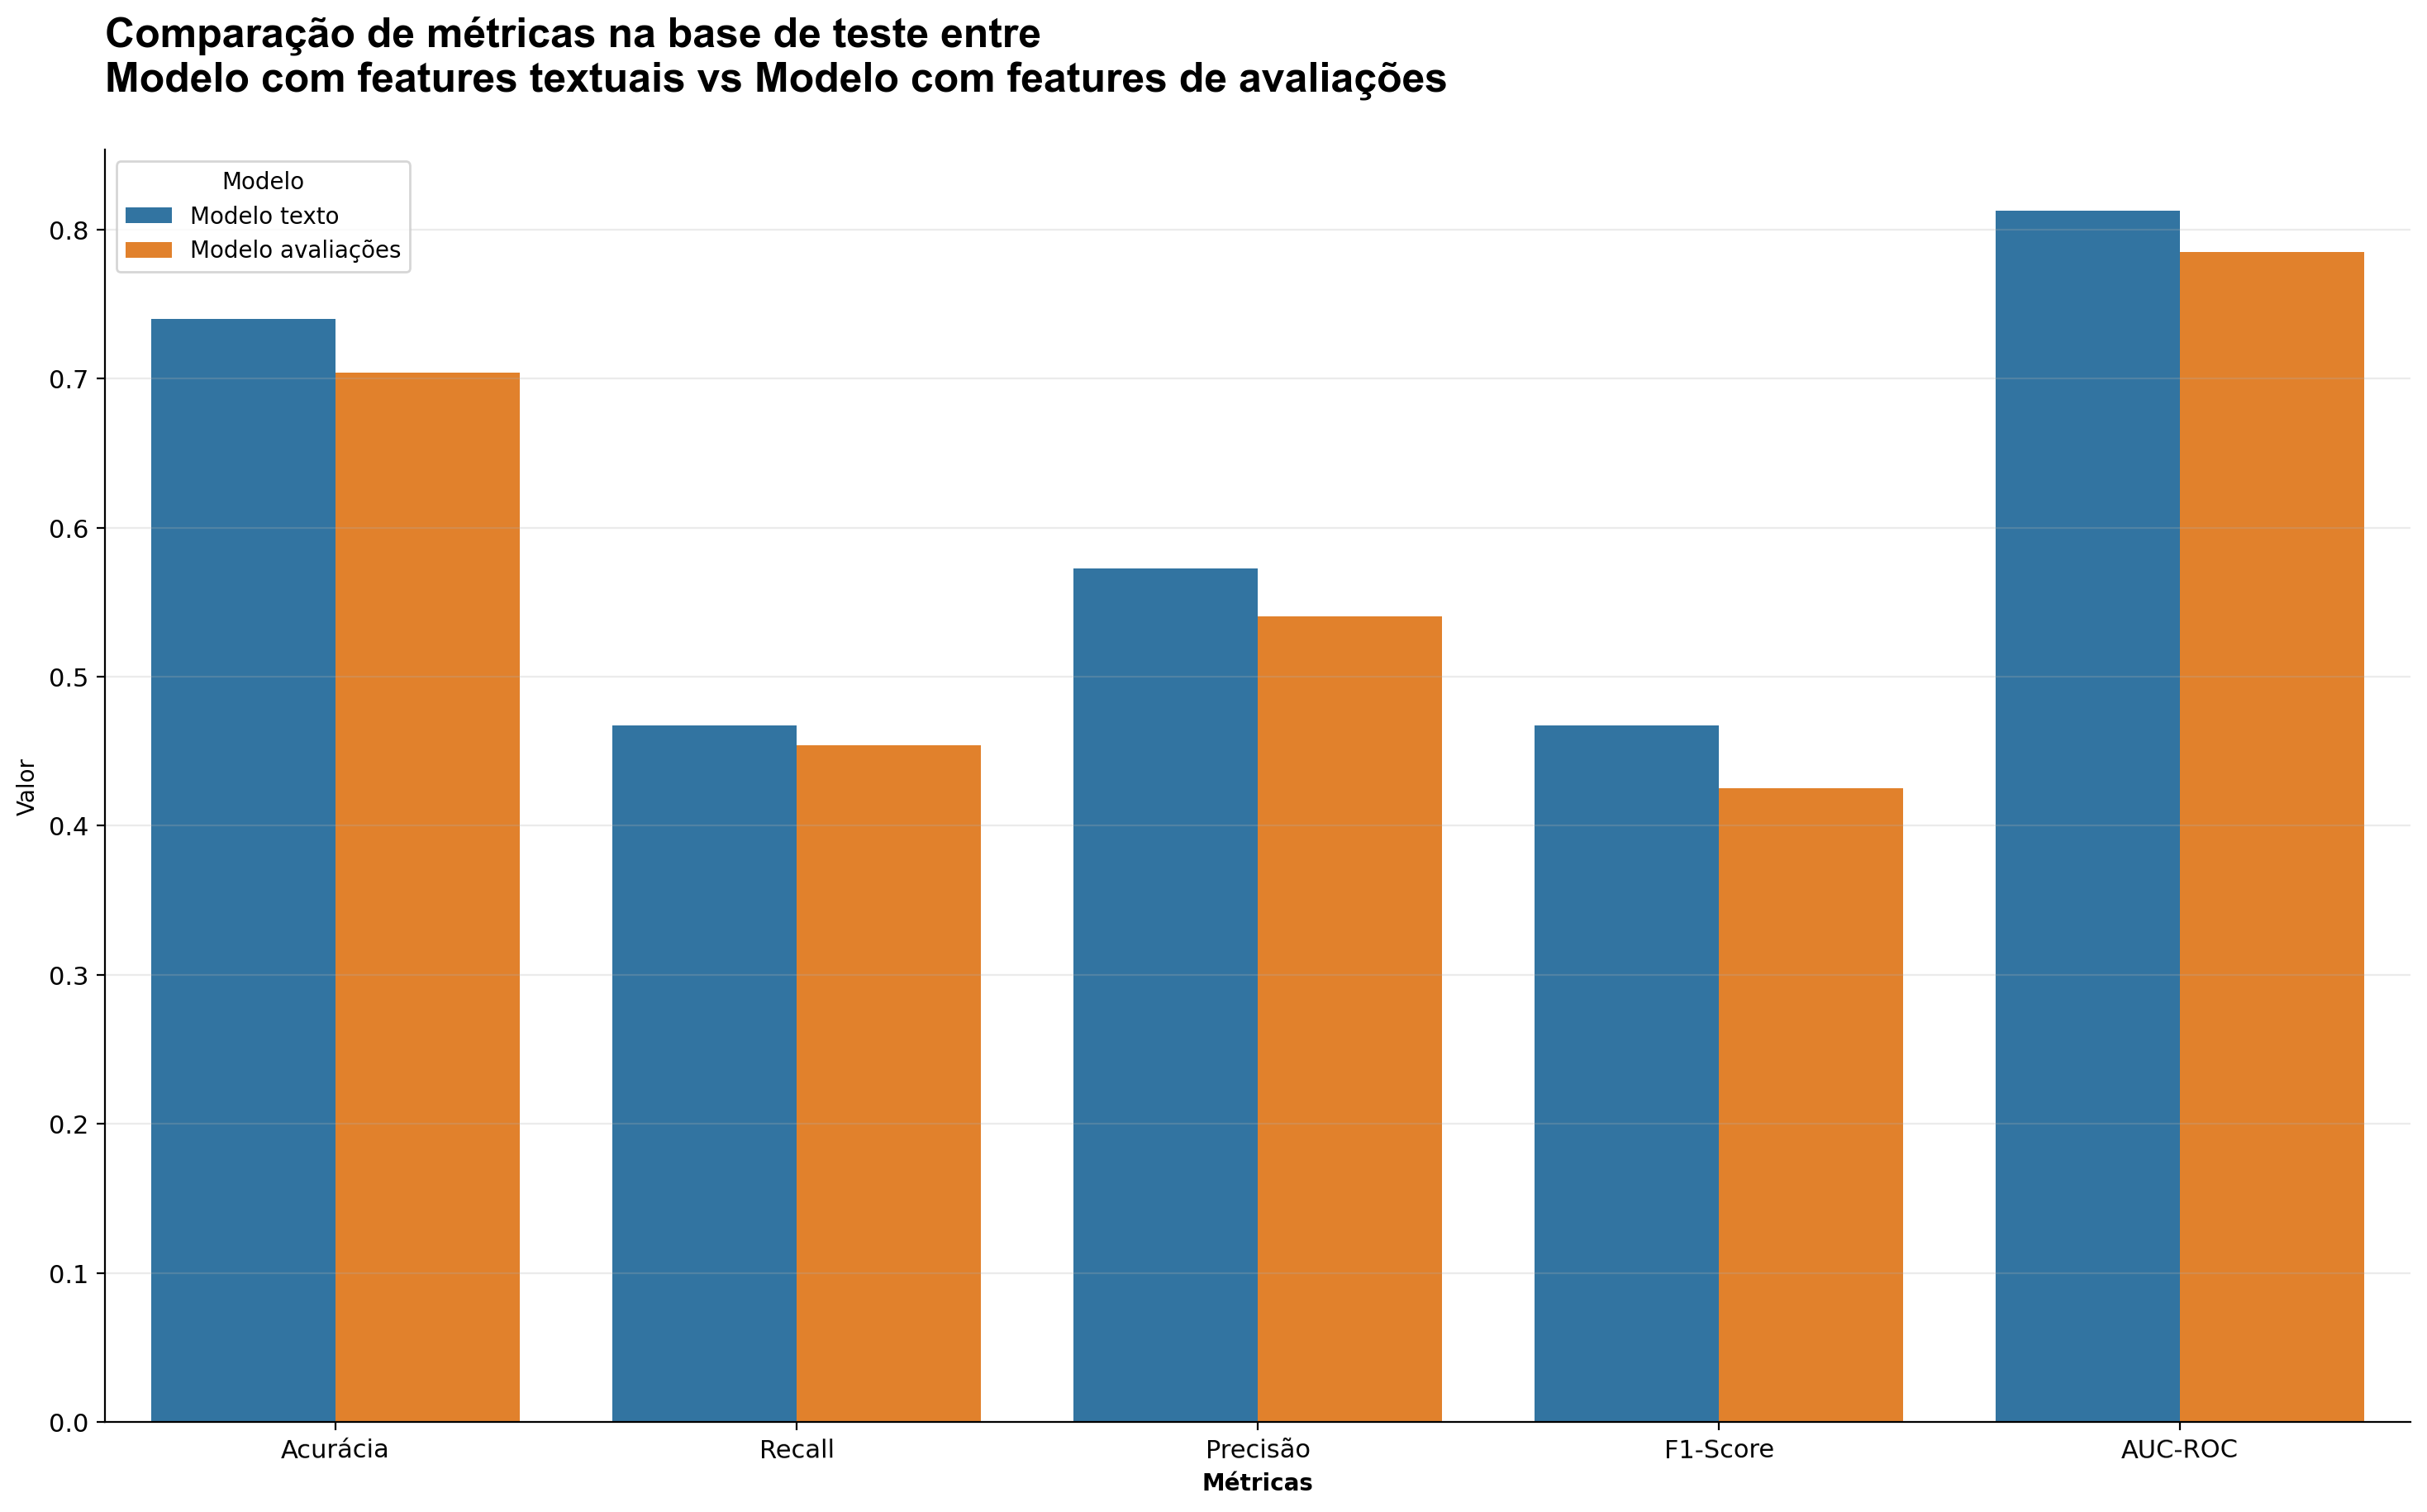

In [45]:
# Previsões
y_pred1 = mod1_predict
y_pred2 = mod2_predict

# Acurácia
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test2, y_pred2)

# Recall
recall1 = recall_score(y_test, y_pred1, average='macro')
recall2 = recall_score(y_test, y_pred2, average='macro')

# Precisão
precision1 = precision_score(y_test, y_pred1, average='macro')
precision2 = precision_score(y_test2, y_pred2, average='macro')

# F1-Score (macro)
f1_1 = f1_score(y_test, y_pred1, average='macro')
f1_2 = f1_score(y_test2, y_pred2, average='macro')

# Para calcular o AUC-ROC para múltiplas classes, binarizar as labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_test_bin2 = label_binarize(y_test2, classes=[0, 1, 2])

# Prever probabilidades para o AUC-ROC
y_prob1 = opt_mod1.predict_proba(X_test)
y_prob2 = opt_mod2.predict_proba(X_test2)

# AUC-ROC
auc_roc1 = roc_auc_score(y_test_bin, y_prob1, average='macro', multi_class='ovo')
auc_roc2 = roc_auc_score(y_test_bin2, y_prob2, average='macro', multi_class='ovo')

# Colocar as métricas em um dicionário para plotar
metrics = {
    'Métrica': ['Acurácia', 'Recall', 'Precisão', 'F1-Score', 'AUC-ROC', 'Acurácia', 'Recall', 'Precisão', 'F1-Score', 'AUC-ROC'],
    'Valor': [accuracy1, recall1, precision1, f1_1, auc_roc1, accuracy2, recall2, precision2, f1_2, auc_roc2],
    'Modelo': ['Modelo texto'] * 5 + ['Modelo avaliações'] * 5
}

# Convertendo dicionário de métricas em DataFrame para visualização
metrics_df = pd.DataFrame(metrics)

# Plotando as métricas
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=metrics_df, palette=['#1f77b4', '#ff7f0e'], ax = ax)
ax.set_title('Comparação de métricas na base de teste entre\nModelo com features textuais vs Modelo com features de avaliações\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax.set_ylabel('Valor')
ax.set_xlabel('Métricas', fontweight = 'bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True, axis = 'y', alpha = .25)
ax.xaxis.set_tick_params(labelsize = 11, labelrotation = .5)
ax.yaxis.set_tick_params(labelsize = 11)

O gráfico acima deixa claro que **o modelo que usou as informações textuais de** ``Review`` **e** ``Review_Title`` **conseguiu um melhor desempenho com os dados de teste em todas as métricas de avaliação**.  
E portanto, é o melhor modelo apra classificação de sentimentos para os dados trabalhados.

In [46]:
# Exportando melhor modelo
joblib.dump(opt_mod1, os.path.join(model_path, 'model.pkl'))

['../model\\model.pkl']